In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Clusterizacao via distancia cosseno

* A distância cosseno mede o ângulo entre dois vetores no espaço vetorial, e não sua magnitude. Isso significa que ela avalia **quão similares são os "perfis"** dos dados, independentemente do tamanho absoluto.


* Em termos práticos:
    - Dois registros com valores proporcionais (mesmo padrão, mesmo "formato") terão distância cosseno ≈ 0
    - Dois registros com perfis muito diferentes terão distância cosseno próxima de 1
    
    
* Vantagens de usar distância cosseno em clusterização:

    - **Foco no padrão**, e não no valor absoluto (útil quando escalas variam ou não são relevantes)
    - **Ideal para dados esparsos**, como textos vetorizados (TF-IDF) ou bases com muitos 0s
    - **Menos sensível a outliers de magnitude** do que a distância euclidiana
    
    
* Quando usar distância cosseno faz sentido:

    - Quando as variáveis representam **composições**, **proporções** ou **comportamentos relativos** (ex: proporção de gastos por categoria, uso percentual de produtos, perfil de consumo)
    - Quando o **tamanho total** do vetor não importa, mas sim **o padrão entre as variáveis**
    - Quando os dados foram codificados via **One-Hot**, **TF-IDF**, ou possuem **muitas variáveis binárias**

# 1 - Gerando uma base

In [2]:
# Gerar base sintética: 7 variáveis quantitativas + 4 qualitativas
X, _ = make_blobs(
    n_samples=1000,
    centers=7,
    n_features=7,
    cluster_std=4,
    random_state=42
)
df = pd.DataFrame(X, columns=[f"num_{i+1}" for i in range(7)])

np.random.seed(42)
categorical_defs = {
    'cat_1': ['red', 'green', 'blue'],
    'cat_2': ['A', 'B', 'C', 'D'],
    'cat_3': ['X', 'Y'],
    'cat_4': ['low', 'medium', 'high']
}
for col, choices in categorical_defs.items():
    df[col] = np.random.choice(choices, size=df.shape[0])

In [3]:
df.head()

,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,cat_2,cat_3,cat_4
0,-2.895713,5.281432,7.653182,-2.538139,-4.622518,-8.889132,-7.991948,blue,C,X,medium
1,-5.726865,-7.157834,-1.673230,-5.388092,-0.796422,0.298413,4.434320,red,C,Y,medium
2,5.579309,3.152474,1.330041,-12.715160,12.916567,9.077377,-0.508582,blue,C,X,medium
3,-6.530744,-10.914936,-1.899482,-2.346882,2.884231,3.933355,5.295152,blue,C,Y,high
4,8.364044,-15.502571,1.173773,-4.852333,-11.444316,5.604105,10.201583,red,D,Y,high


# 2 - Transformando as variaveis

* Para aplicar a distancia cosseno é necessario: 
    * Encoding nas variaveis qualitativas (neste caso, one-hot)
    * Padronizacao das escalas das variaveis quantitativas (Standard Scaler)
    * **Normalização dos vetores (Norma L2 = 1). Sendo esta transformacao, a mais essencial, a distância cosseno só faz sentido se os vetores forem comparáveis em direção**
       * Isso garante que a distância cosseno seja equivalente ao seno do ângulo entre vetores, variando de 0 (iguais) a 1 (ortogonais)

In [4]:
# One-Hot Encoding das variáveis qualitativas
cat_cols = list(categorical_defs.keys())
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = ohe.fit_transform(df[cat_cols])
cat_ohe_cols = ohe.get_feature_names_out(cat_cols)

In [5]:
# Escalonar variáveis numéricas
num_cols = [f"num_{i+1}" for i in range(6)]
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[num_cols])

In [6]:
# Concatenar numéricas e dummies, em seguida normalizar para usar a distância cosseno
X_combined = np.hstack([X_num_scaled, cat_encoded])
normalizer = Normalizer(norm='l2')
X_norm = normalizer.fit_transform(X_combined)

# 3 - Definicao da quantidade de clusters

* Ha algumas formas diferentes de escolher a quantidade de clusters, abaixo disponho algumas alternativas


   * **Silhouette Score**: Avalia o quão bem cada ponto está alocado dentro de seu cluster comparado aos outros clusters.
        * Varia de -1 a +1: a) Próximo de +1: ponto bem alocado (longe dos outros clusters); b) Próximo de 0: ponto na borda entre clusters; c) Negativo: ponto potencialmente mal alocado
       
        
   * **Calinski-Harabasz Score**: Razão entre a dispersão entre clusters e a dispersão dentro dos clusters.
        * Quanto maior o valor, melhor a separação entre clusters.
        
        
   * **Davies-Bouldin Score**: A média das similaridades entre cada cluster e o mais similar a ele, considerando dispersão interna e distância entre clusters
        * Valores pequenos indicam que os clusters estão bem separados e são compactos
        
        
* Para escolher o número ideal de clusters:

    * Plote os três scores para diferentes valores de k (ex: de 2 a 10).

        * Busque o valor de k que:

            * Maximiza Silhouette

            * Maximiza Calinski-Harabasz

            * Minimiza Davies-Bouldin

In [13]:
# Testar k de 2 a 10 e calcular métricas de validação
k_values = range(2, 11)
sil_scores, ch_scores, db_scores = [], [], []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_norm)
    sil_scores.append(silhouette_score(X_norm, labels, metric='cosine'))
    ch_scores.append(calinski_harabasz_score(X_norm, labels))
    db_scores.append(davies_bouldin_score(X_norm, labels))

In [14]:
# Consolidar resultados
results = pd.DataFrame({
    'k': list(k_values),
    'Silhouette Score (cosine)': sil_scores,
    'Calinski-Harabasz Score': ch_scores,
    'Davies-Bouldin Score': db_scores
})

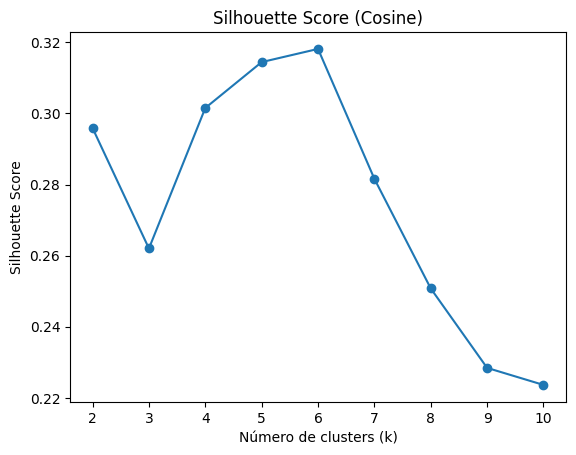

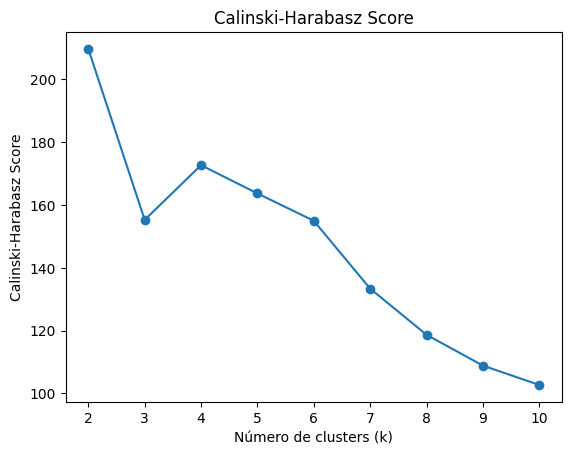

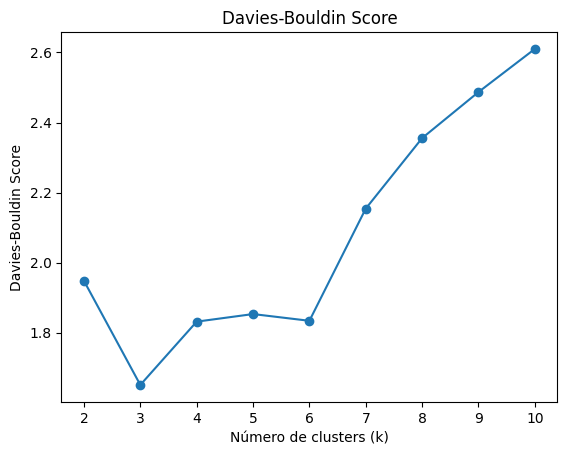

In [15]:
# Plots das métricas
plt.figure()
plt.plot(results['k'], results['Silhouette Score (cosine)'], marker='o')
plt.title('Silhouette Score (Cosine)')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

plt.figure()
plt.plot(results['k'], results['Calinski-Harabasz Score'], marker='o')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

plt.figure()
plt.plot(results['k'], results['Davies-Bouldin Score'], marker='o')
plt.title('Davies-Bouldin Score')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

# 4 - Ajuste dos clusters e identificacao das caracteristicas de cada cluster

* Dado o ajuste dos clusters, identifica-se como cada variavel explicativa se comporta em cada grupo

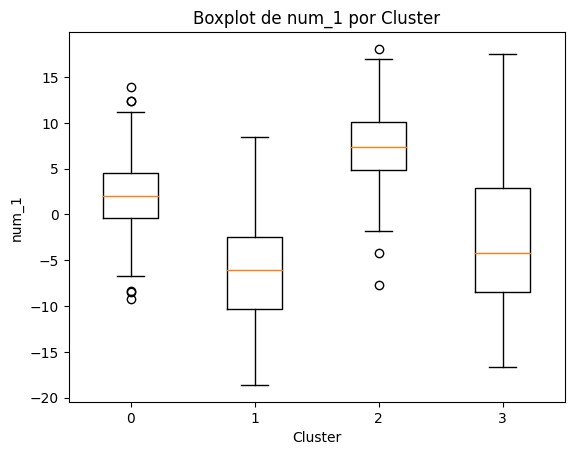

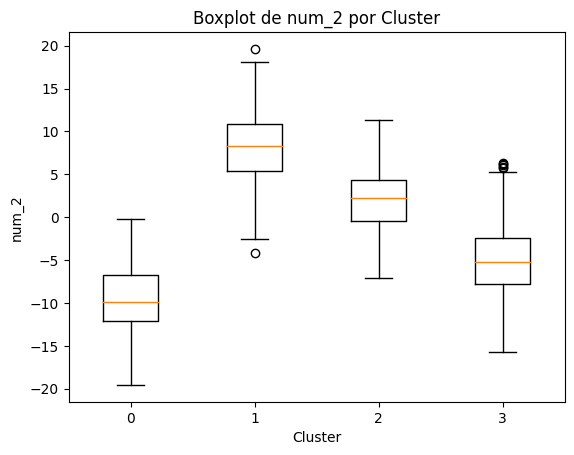

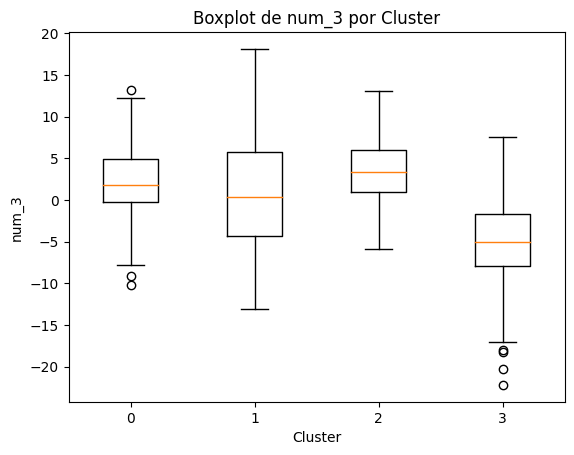

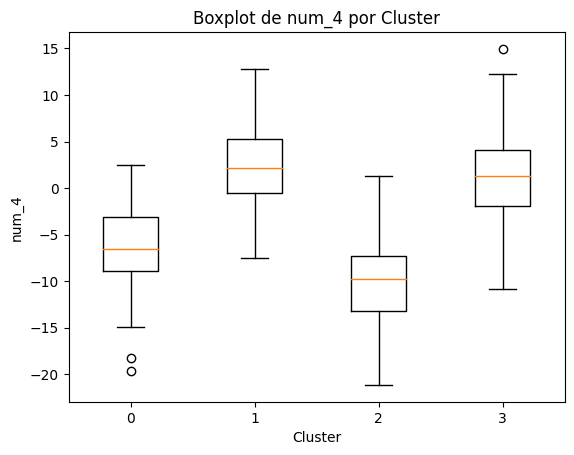

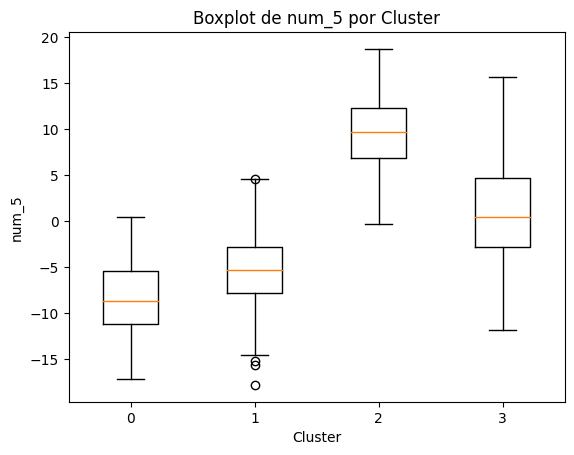

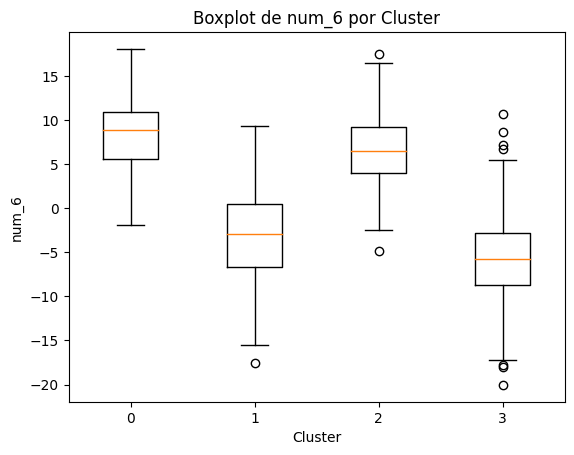

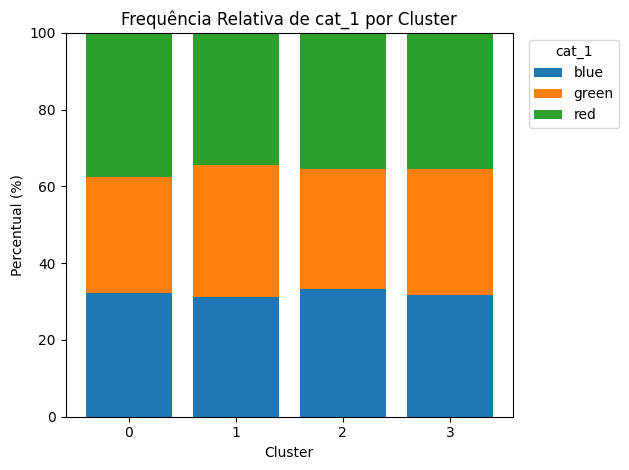

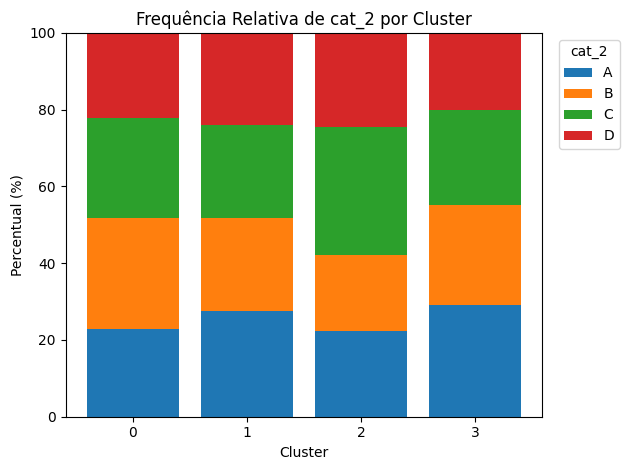

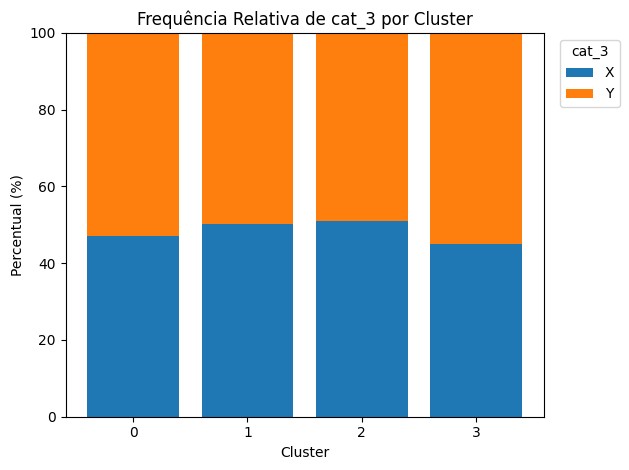

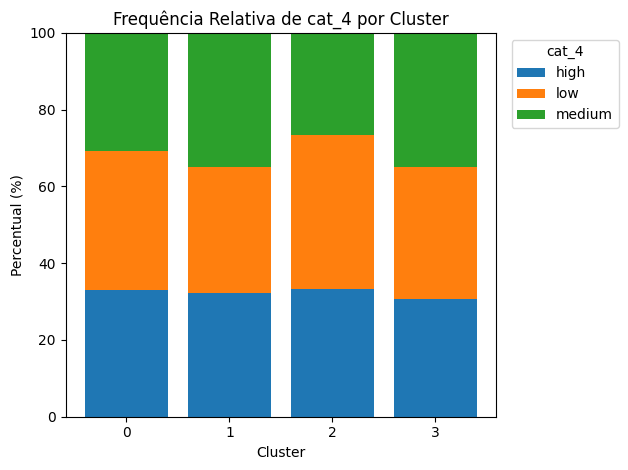

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# --- 1. Ajuste KMeans e construção de df_clusters ---
n_clusters = 4  # altere para o número de clusters desejado
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_norm)  # X_norm: matriz normalizada (num + dummies)
df_clusters = df.copy()           # df: DataFrame original com num_cols e cat_cols
df_clusters['cluster'] = labels

# --- 2. Boxplots para variáveis numéricas por cluster ---
for col in num_cols:  # num_cols = ['num_1', ..., 'num_6']
    plt.figure()
    data = [df_clusters[df_clusters['cluster'] == k][col] 
            for k in range(n_clusters)]
    plt.boxplot(data, labels=list(range(n_clusters)))
    plt.title(f'Boxplot de {col} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.show()

# --- 3. Barras empilhadas para variáveis categóricas por cluster ---
for col in cat_cols:
    # value_counts(normalize=True) já retorna fração de cada categoria
    prop = (
        df_clusters
        .groupby('cluster')[col]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    # prop.loc[k, cat] = % da categoria 'cat' no cluster k (soma por linha = 1)

    # --- 3. Plot empilhado em % ---
    clusters = prop.index.values
    categories = prop.columns.values
    x = np.arange(len(clusters))
    bottom = np.zeros(len(clusters))

    plt.figure()
    for cat in categories:
        heights = prop[cat].values * 100  # converter para %
        plt.bar(x, heights, bottom=bottom, label=str(cat))
        bottom += heights

    plt.title(f'Frequência Relativa de {col} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Percentual (%)')
    plt.xticks(x, clusters)
    plt.ylim(0, 100)
    plt.legend(title=col, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 5 - Variaveis mais relevantes para definir os clusters

* Dado o mapeamento de como as variaveis se comportam, podemos rodar um modelo preditivo, focado em prever o cluster de cada observacao, e depois pedir a feature importance
* As variaveis com maior feature importance serao, provavelmente, as que mais diferenciaram os clusters entre si

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Pipeline de pré-processamento exato do clustering:
pre = ColumnTransformer([
    ('scale',   StandardScaler(), num_cols),
    ('ohe',     OneHotEncoder(),  cat_cols),
])

pipe = make_pipeline(pre,
                     DecisionTreeClassifier(random_state=42,
                                            max_depth=12))  # controle a complexidade

X = df_clusters[num_cols + cat_cols]
y = df_clusters['cluster']
pipe.fit(X, y)

# Extrair importâncias
feat_names = (
    pipe.named_steps['columntransformer']
        .get_feature_names_out()
)
importances = pd.Series(
    pipe.named_steps['decisiontreeclassifier'].feature_importances_,
    index=feat_names
).sort_values(ascending=False)

print("Top 10 features por importância do DecisionTreeClassifier:")
print(importances.head(10))

Top 10 features por importância do DecisionTreeClassifier:
scale__num_2       0.321278
scale__num_5       0.277410
scale__num_6       0.261070
scale__num_3       0.049612
scale__num_1       0.044449
scale__num_4       0.035052
ohe__cat_4_high    0.002853
ohe__cat_4_low     0.002568
ohe__cat_3_X       0.002140
ohe__cat_2_A       0.002140
dtype: float64


# 6 - Testes estatisticos para verificar se as diferencas entre os clusters é significativa

* Complementar a etapa anterior, , é fundamental ir além da visualização dos grupos e investigar se as diferenças observadas entre os clusters são estatisticamente significativas — ou seja, se elas não ocorreram apenas por acaso.


* Essa etapa serve para validar empiricamente que os clusters realmente apresentam comportamentos distintos nas variáveis utilizadas (sejam elas numéricas ou categóricas). Isso dá mais credibilidade ao modelo e gera insights mais robustos.


* Nesta seção, aplicamos:

     * ANOVA e Kruskal–Wallis para variáveis numéricas: Verificam se há diferença significativa nas médias/medianas entre os clusters.

        * ANOVA pressupõe normalidade e variância homogênea.

        * Kruskal–Wallis é não paramétrico (mais robusto em muitos casos).

     * Qui-quadrado (Chi-square) para variáveis categóricas:
        * Verifica se a distribuição das categorias varia significativamente entre os clusters.
        * Também identificamos quais combinações categoria-cluster mais distorcem a distribuição esperada, destacando os principais "drivers" da separação entre grupos.


* Com p-valor < 0.05, temos que a diferenca sao estatisticamente significativas

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, kruskal, chi2_contingency

# Testes nas variáveis numéricas ---
print("=== ANOVA e Kruskal–Wallis por variável numérica ===\n")
for col in num_cols:
    # lista de arrays, cada array = valores da variável em um cluster
    grupos = [ df_clusters[df_clusters['cluster']==k][col].values
               for k in range(n_clusters) ]
    # ANOVA one‐way (presume normalidade e variâncias iguais)
    stat_f, p_f = f_oneway(*grupos)
    # Kruskal–Wallis (não paramétrico)
    stat_k, p_k = kruskal(*grupos)
    print(f"{col:10s}  ANOVA F={stat_f:6.3f}, p={p_f:.3e}  |  "
          f"Kruskal H={stat_k:6.3f}, p={p_k:.3e}")
print()

# Chi‐square nas variáveis categóricas ---
print("=== Chi-square por variável categórica ===\n")
for col in cat_cols:
    # tabela de contingência: linhas=categories, colunas=clusters
    tb = pd.crosstab(df_clusters[col], df_clusters['cluster'])
    chi2, p, dof, exp = chi2_contingency(tb)
    print(f"{col:10s}  χ²={chi2:6.1f}, p={p:.3e}, dof={dof}")
    # opcional: ver quais categorias distorcem mais
    resid = (tb - exp) / np.sqrt(exp)  # resíduos ajustados
    # pega as 3 maiores diferenças absolutas
    flat = resid.abs().stack().sort_values(ascending=False)
    top3 = flat.head(3)
    print("  Top categorias/cluster (|resid|):")
    for (cat, cl), val in top3.items():
        print(f"    {col}={cat}, cluster={cl} → |resid|={val:.2f}")
    print()

=== ANOVA e Kruskal–Wallis por variável numérica ===

num_1       ANOVA F=196.501, p=4.337e-100  |  Kruskal H=368.788, p=1.274e-79
num_2       ANOVA F=868.659, p=2.028e-277  |  Kruskal H=722.804, p=2.383e-156
num_3       ANOVA F=156.917, p=2.775e-83  |  Kruskal H=342.517, p=6.222e-74
num_4       ANOVA F=421.887, p=8.016e-177  |  Kruskal H=519.410, p=2.966e-112
num_5       ANOVA F=486.351, p=1.484e-194  |  Kruskal H=579.687, p=2.552e-125
num_6       ANOVA F=510.227, p=9.032e-201  |  Kruskal H=576.933, p=1.009e-124

=== Chi-square por variável categórica ===

cat_1       χ²=   1.0, p=9.837e-01, dof=6
  Top categorias/cluster (|resid|):
    cat_1=green, cluster=1 → |resid|=0.53
    cat_1=green, cluster=0 → |resid|=0.51
    cat_1=red, cluster=0 → |resid|=0.43

cat_2       χ²=  10.9, p=2.836e-01, dof=9
  Top categorias/cluster (|resid|):
    cat_2=C, cluster=2 → |resid|=1.74
    cat_2=B, cluster=2 → |resid|=1.30
    cat_2=A, cluster=2 → |resid|=1.00

cat_3       χ²=   2.6, p=4.631e-01, dof=